### **Data Engineering Project**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

#!unzip "/content/gdrive/MyDrive/data.zip" -d "/content/gdrive/MyDrive/ColabNotebooks/"

In [2]:
#Importing Libraries
import pandas as pd, numpy as np , math , seaborn as sns, matplotlib.pyplot as plt
from datetime import datetime


In [3]:
#Reading Visitor Log Data 
vld=pd.read_csv("/content/gdrive/MyDrive/ColabNotebooks/data/VisitorLogsData.csv")

In [4]:
#Reading User Data
user=pd.read_csv("/content/gdrive/MyDrive/ColabNotebooks/data/userTable.csv")

As we have to concentrate on the users, hence droping the visitor information Where UserID is null and there is no chance of imputation.

In [5]:
df=vld.drop(index=vld[vld.UserID.isnull()].index  )
df=df.drop_duplicates()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590897 entries, 14 to 6099998
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   webClientID    590897 non-null  object
 1   VisitDateTime  542268 non-null  object
 2   ProductID      543386 non-null  object
 3   UserID         590897 non-null  object
 4   Activity       510656 non-null  object
 5   Browser        590897 non-null  object
 6   OS             590897 non-null  object
 7   City           376804 non-null  object
 8   Country        551724 non-null  object
dtypes: object(9)
memory usage: 45.1+ MB


In [7]:
# Droping unnecessary columns
df.drop(columns=['Country','City','webClientID','Browser'],inplace=True)

In [8]:
df.head()

,VisitDateTime,ProductID,UserID,Activity,OS
14,1526366895249000000,Pr100017,U106593,click,Android
21,1527058921790000000,Pr101008,U108297,NaN,Android
23,2018-05-10 06:28:53.391,Pr100241,U132443,NaN,Windows
24,2018-05-08 12:40:02.153,pr100495,U134616,click,Windows
33,2018-05-11 15:35:43.689,Pr100363,U130784,click,Chrome OS


In [9]:
#merging Visitor log data with User Data 
df2=pd.merge(df,user[['UserID','User Segment']],how='inner',on='UserID'  )

### Data Preprocessing

In [10]:
# Checking the Product Id
df2.ProductID.astype(str).str[0].value_counts(dropna=False,normalize=True)

P    0.606557
p    0.313038
n    0.080405
Name: ProductID, dtype: float64

In [11]:
#Modified the lowercase "p" in the productid to Uppercase
df2["ProductID"][~df2.ProductID.isna()]=df2[~df2.ProductID.isna()].ProductID.astype(str).apply(lambda x: x.replace('p','P'))

In [12]:
# Checking the Activity variable
df2.Activity.value_counts(dropna=False,normalize=True)*100

click       48.090276
pageload    20.875212
NaN         13.579524
CLICK       12.230219
PAGELOAD     5.224768
Name: Activity, dtype: float64

In [13]:
# Activity variable data is case insensitive, which causing more unique Activity, so replacing 
df2['Activity']=df2.Activity.replace({'click' : 'CLICK','pageload':'PAGELOAD'})

In [14]:
df2.Activity.value_counts(dropna=False,normalize=True)*100

CLICK       60.320496
PAGELOAD    26.099980
NaN         13.579524
Name: Activity, dtype: float64

In [15]:
#Checking OS variable
df2.OS.value_counts(dropna=False,normalize=True)*100

Windows      66.121168
Android      12.943711
Mac OS X      7.824375
windows       5.063996
Linux         3.401439
Ubuntu        1.878331
android       0.968020
iOS           0.639367
mac os x      0.582335
linux         0.258251
ubuntu        0.140803
Chrome OS     0.096125
ios           0.048063
Fedora        0.020139
chrome os     0.009139
Tizen         0.002200
fedora        0.002200
tizen         0.000338
Name: OS, dtype: float64

In [16]:
# OS variable data is case insensitive, which causing more unique OS, consolidating the data to uppder case
df2['OS'][~df2.OS.isnull()]=df2[~df2.OS.isnull()].OS.apply(lambda x: x.upper())

In [17]:
df2.OS.value_counts(dropna=False,normalize=True)*100

WINDOWS      71.185164
ANDROID      13.911731
MAC OS X      8.406710
LINUX         3.659690
UBUNTU        2.019134
IOS           0.687429
CHROME OS     0.105264
FEDORA        0.022339
TIZEN         0.002539
Name: OS, dtype: float64

In [18]:
# As the visitdatetime variabel has two formats, hence modifing the unix format to Date Time format
# Unix time format : first 10 caracters - Date Time , next 9 characters are nano seconds

df2['VisitDateTime']=[datetime.fromtimestamp(int(x[0:10])).strftime('%Y-%m-%d %H:%M:%S')+'.'+str(int(int(x[10:])/10**6))  if x.isdigit()==True else x for x in df2['VisitDateTime'].astype(str)]

In [19]:
# After manuplation, null values are replaces by string nan
df2[df2.VisitDateTime=='nan'].shape

(48629, 6)

In [20]:
# hence replacing them with real nan 
df2.VisitDateTime=df2.VisitDateTime.replace({'nan':np.nan})

### Missing Value Imputation 

VisitDateTime - Imputed with Day - 'YY-mm-dd 00:00:00.000'

In [21]:
#Derived Visitday Variable from VisitDate Time variable for simple count of Day

df2['Visitday']=df2['VisitDateTime'].astype(str).apply(lambda x : x.split(' ')[0])

In [23]:
# replacing null of Visitdatetime column with the day having max of (user,product,Visitday) combination, if max count is same then taken the latest visited datetime

c=df2.copy()
c=c[(~(c.VisitDateTime.isnull()))  &(~(c.ProductID.isnull()))]

p=c.groupby(['ProductID','UserID','Visitday'])['VisitDateTime'].count().reset_index()
#p=pd.merge(p,c.groupby(['UserID','ProductID','Visitday'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','ProductID','Visitday'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime.astype(str)


In [24]:
q=p.groupby(['UserID','ProductID'])['VisitDateTime'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime']),'inner',on=['UOS','ProductID']  ,   )
r=pd.merge(r.groupby(['UserID','ProductID'])['Visitday'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime']),'inner',on=['UserID','ProductID','Visitday'])
#r.sort_values('VisitDateTime_Actual',inplace=True)

In [25]:
z=pd.merge(df2[(df2.VisitDateTime.isnull()) ],r,'left',on=['UserID','ProductID'])

z.drop(columns=['Visitday_x'],inplace=True)
z.VisitDateTime=z.Visitday_y+' 00:00:00.000'
z.shape

(48629, 7)

In [26]:

z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment', 'Visitday']
df2=pd.concat([z,df2[~df2.VisitDateTime.isnull()]])

In [27]:
df2[df2.VisitDateTime.isnull()].shape

(9468, 7)

In [28]:
# replacing null of Visitdatetime column with user max appearence 

c=df2.copy()
c=c[(~(c.VisitDateTime.isnull())) &(~(c.ProductID.isnull()))]

p=c.groupby(['UserID','Visitday'])['VisitDateTime'].count().reset_index()
#p=pd.merge(p,c.groupby(['UserID','ProductID','Visitday'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','ProductID','Visitday'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime.astype(str)

In [29]:
q=p.groupby(['UserID'])['VisitDateTime'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime']),'inner',on=['UOS']  ,   )
r=pd.merge(r.groupby(['UserID'])['Visitday'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime']),'inner',on=['UserID','Visitday'])
#r.sort_values('VisitDateTime_Actual',inplace=True)

In [30]:
z=pd.merge(df2[(df2.VisitDateTime.isnull()) ],r,'left',on=['UserID'])

z.drop(columns=['Visitday_x'],inplace=True)
z.VisitDateTime=z.Visitday_y+' 00:00:00.000'
z.head()

,VisitDateTime,ProductID,UserID,Activity,OS,User Segment,Visitday_y
0,2018-05-15 00:00:00.000,NaN,U106593,CLICK,ANDROID,B,2018-05-15
1,2018-05-11 00:00:00.000,Pr100853,U130784,PAGELOAD,CHROME OS,B,2018-05-11
2,2018-05-20 00:00:00.000,NaN,U120287,CLICK,WINDOWS,C,2018-05-20
3,2018-05-20 00:00:00.000,NaN,U120287,CLICK,WINDOWS,C,2018-05-20
4,2018-05-20 00:00:00.000,NaN,U120287,CLICK,WINDOWS,C,2018-05-20


In [31]:
#z.columns=['webClientID','VisitDateTime', 'ProductID', 'UserID', 'Activity','Browser', 'OS','City','Country','User Segment', 'Visitday']

z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment', 'Visitday']
df2=pd.concat([z,df2[~df2.VisitDateTime.isnull()]])

In [32]:
df2[df2.VisitDateTime.isnull()].shape

(824, 7)

In [33]:
# replacing null of Visitdatetime column with the day having max of (User Segment,product,Visitday) combination, if max count is same then taken the latest visited date

c=df2.copy()
c=c[(~(c.VisitDateTime.isnull()))  ]

p=c.groupby(['ProductID','User Segment','Visitday'])['VisitDateTime'].count().reset_index()
#p=pd.merge(p,c.groupby(['UserID','ProductID','Visitday'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','ProductID','Visitday'],suffixes=['_count','_Actual'])
p['UOS']=p['User Segment']+p.VisitDateTime.astype(str)


In [34]:
q=p.groupby(['User Segment','ProductID'])['VisitDateTime'].max().reset_index()
q['UOS']=q['User Segment']+q.VisitDateTime.astype(str)
r=pd.merge(q,p.drop(columns=['User Segment','VisitDateTime']),'inner',on=['UOS','ProductID']  ,   )
r=pd.merge(r.groupby(['User Segment','ProductID'])['Visitday'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime']),'inner',on=['User Segment','ProductID','Visitday'])
#r.sort_values('VisitDateTime_Actual',inplace=True)

In [35]:
z=pd.merge(df2[(df2.VisitDateTime.isnull()) ],r,'left',on=['User Segment','ProductID'])

z.drop(columns=['Visitday_x'],inplace=True)
z.VisitDateTime=z.Visitday_y+' 00:00:00.000'
z.shape

(824, 7)

In [36]:

z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment', 'Visitday']
df2=pd.concat([z,df2[~df2.VisitDateTime.isnull()]])


In [38]:
df2.drop(columns=['Visitday'],inplace=True)

In [39]:
#Shows 1 time visitors with visitordatetime null all the time
x1=df2.groupby(['UserID'],dropna=False)['OS'].count().reset_index()
x2=pd.merge(x1[x1.OS.isin([1,2,3,4])],df2,'left','UserID')

In [40]:
missing_users_info=df2[df2.VisitDateTime.isnull()]

In [41]:
missing_users_info=missing_users_info[~missing_users_info.UserID.isin(df2[~df2.VisitDateTime.isnull()].UserID)]

In [42]:
# all the 66 users has visitDateTime null, hence seperated for further use at the time of Feature derivation
missing_users_info.UserID.nunique()

66

In [43]:
#Converting the format of Visitdatetime to Datetime
df2['VisitDateTime']=pd.to_datetime(df2['VisitDateTime'])


In [44]:
df2.UserID.nunique()

34050

In [45]:
df2=df2[~df2.VisitDateTime.isnull()]

In [46]:
# After removing 66 Users we have below count
df2.UserID.nunique()

33984

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590818 entries, 0 to 590896
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   VisitDateTime  590818 non-null  datetime64[ns]
 1   ProductID      543374 non-null  object        
 2   UserID         590818 non-null  object        
 3   Activity       510588 non-null  object        
 4   OS             590818 non-null  object        
 5   User Segment   590818 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 31.6+ MB


ProductID

In [48]:
df2['Visitday']=df2['VisitDateTime'].astype(str).apply(lambda x : x.split(' ')[0])

In [49]:
# product imputation by user , product on same day
c=df2.copy()
c=c[~c.ProductID.isnull()]

p=c.groupby(['ProductID','UserID','Visitday'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,c.groupby(['UserID','ProductID','Visitday'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','ProductID','Visitday'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime_count.astype(str)
q=p.groupby(['UserID','Visitday'])['VisitDateTime_count'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime_count']),'inner',on=['UOS','Visitday']  ,   )
r=pd.merge(r.groupby(['UserID','Visitday'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual','Visitday'])
r.sort_values('VisitDateTime_Actual',inplace=True)

In [50]:
z=pd.merge(df2[df2.ProductID.isnull()],r.drop(columns='VisitDateTime_Actual'),'left',on=['UserID','Visitday'])

z.drop(columns=['ProductID_x'],inplace=True)
z.head()

,VisitDateTime,UserID,Activity,OS,User Segment,Visitday,ProductID_y
0,2018-05-15,U106593,CLICK,ANDROID,B,2018-05-15,Pr100017
1,2018-05-20,U120287,CLICK,WINDOWS,C,2018-05-20,Pr102152
2,2018-05-20,U120287,CLICK,WINDOWS,C,2018-05-20,Pr102152
3,2018-05-20,U120287,CLICK,WINDOWS,C,2018-05-20,Pr102152
4,2018-05-20,U120287,CLICK,WINDOWS,C,2018-05-20,Pr102152


In [51]:
z=z.iloc[:,[0,6,1,2,3,4,5]]
z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment', 'Visitday']
df2=pd.concat([z,df2[~df2.ProductID.isnull()]])

In [52]:
# Products , imputing the products with most seen product by user

c=df2.copy()
c=c[~c.ProductID.isnull()]

p=c.groupby(['ProductID','UserID'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,c.groupby(['UserID','ProductID'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','ProductID'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime_count.astype(str)
q=p.groupby(['UserID'])['VisitDateTime_count'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime_count']),'inner',on=['UOS']  ,   )
r=pd.merge(r.groupby(['UserID'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual'])
r.sort_values('VisitDateTime_Actual',inplace=True)

In [53]:
z=pd.merge(df2[df2.ProductID.isnull()],r.drop(columns='VisitDateTime_Actual'),'left',on=['UserID'])

z.drop(columns=['ProductID_x'],inplace=True)
z.head()


,VisitDateTime,UserID,Activity,OS,User Segment,Visitday,ProductID_y
0,2018-05-23 04:12:44.615,U103943,NaN,WINDOWS,C,2018-05-23,Pr100413
1,2018-05-09 14:14:43.727,U105355,PAGELOAD,WINDOWS,C,2018-05-09,Pr101702
2,2018-05-14 04:51:43.183,U119694,NaN,WINDOWS,A,2018-05-14,NaN
3,2018-05-17 11:39:41.492,U124072,CLICK,LINUX,B,2018-05-17,Pr100393
4,2018-05-10 16:46:38.551,U120495,PAGELOAD,MAC OS X,A,2018-05-10,Pr100096


In [54]:
z=z.iloc[:,[0,6,1,2,3,4,5]]
z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment', 'Visitday']
df2=pd.concat([z,df2[~df2.ProductID.isnull()]])

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590818 entries, 0 to 590896
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   VisitDateTime  590818 non-null  datetime64[ns]
 1   ProductID      590343 non-null  object        
 2   UserID         590818 non-null  object        
 3   Activity       510588 non-null  object        
 4   OS             590818 non-null  object        
 5   User Segment   590818 non-null  object        
 6   Visitday       590818 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 36.1+ MB


In [56]:
# product imputation by user segment , product on same day
c=df2.copy()
c=c[~c.ProductID.isnull()]

p=c.groupby(['ProductID','User Segment','Visitday'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,c.groupby(['User Segment','ProductID','Visitday'])['VisitDateTime'].max().reset_index(),'inner',on=['User Segment','ProductID','Visitday'],suffixes=['_count','_Actual'])
p['UOS']=p['User Segment']+p.VisitDateTime_count.astype(str)
q=p.groupby(['User Segment','Visitday'])['VisitDateTime_count'].max().reset_index()
q['UOS']=q['User Segment']+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['User Segment','VisitDateTime_count']),'inner',on=['UOS','Visitday']  ,   )
r=pd.merge(r.groupby(['User Segment','Visitday'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['User Segment','VisitDateTime_Actual','Visitday'])
r.sort_values('VisitDateTime_Actual',inplace=True)

In [57]:
z=pd.merge(df2[df2.ProductID.isnull()],r.drop(columns='VisitDateTime_Actual'),'left',on=['User Segment','Visitday'])

z.drop(columns=['ProductID_x'],inplace=True)
z.head()

,VisitDateTime,UserID,Activity,OS,User Segment,Visitday,ProductID_y
0,2018-05-14 04:51:43.183,U119694,NaN,WINDOWS,A,2018-05-14,Pr100166
1,2018-05-24 13:51:52.920,U102407,PAGELOAD,WINDOWS,A,2018-05-24,Pr101042
2,2018-05-21 04:45:51.706,U119516,PAGELOAD,WINDOWS,A,2018-05-21,Pr101042
3,2018-05-12 09:53:29.059,U129991,PAGELOAD,WINDOWS,C,2018-05-12,Pr100200
4,2018-05-13 16:47:58.124,U128594,PAGELOAD,ANDROID,B,2018-05-13,Pr100102


In [58]:
z=z.iloc[:,[0,6,1,2,3,4,5]]
z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment', 'Visitday']
df2=pd.concat([z,df2[~df2.ProductID.isnull()]])

In [61]:
#productID imputation is completed
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590818 entries, 0 to 590896
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   VisitDateTime  590818 non-null  datetime64[ns]
 1   ProductID      590818 non-null  object        
 2   UserID         590818 non-null  object        
 3   Activity       510588 non-null  object        
 4   OS             590818 non-null  object        
 5   User Segment   590818 non-null  object        
 6   Visitday       590818 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 36.1+ MB


In [62]:
df2.drop(columns='Visitday',inplace=True)

Activity 

In [63]:
# Activity Imputation, using user and product 

c=df2.copy()
c=c[~c.Activity.isnull()]

p=c.groupby(['Activity','UserID','ProductID'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,c.groupby(['UserID','Activity','ProductID'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','Activity','ProductID'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime_count.astype(str)
q=p.groupby(['UserID','ProductID'])['VisitDateTime_count'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime_count']),'inner',on=['UOS','ProductID']  ,   )
r=pd.merge(r.groupby(['UserID','ProductID'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual','ProductID'])
r.sort_values('VisitDateTime_Actual',inplace=True)

In [64]:
r = r.drop_duplicates(subset=['UserID','ProductID','VisitDateTime_Actual'], keep="first")

In [65]:
z=pd.merge(df2[df2.Activity.isnull()],r.drop(columns='VisitDateTime_Actual'),'left',on=['UserID','ProductID'])

z.drop(columns=['Activity_x'],inplace=True)
z.head()

,VisitDateTime,ProductID,UserID,OS,User Segment,Activity_y
0,2018-05-14 04:51:43.183,Pr100166,U119694,WINDOWS,A,NaN
1,2018-05-09 13:21:43.747,Pr101042,U133427,ANDROID,A,NaN
2,2018-05-13 07:03:48.691,Pr100102,U129163,ANDROID,B,NaN
3,2018-05-08 04:37:31.092,Pr101042,U135379,ANDROID,B,PAGELOAD
4,2018-05-17 08:47:00.249,Pr101042,U124259,WINDOWS,A,NaN


In [66]:
z=z.iloc[:,[0,1,2,5,3,4]]
z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment']
df2=pd.concat([z,df2[~df2.Activity.isnull()]])

In [69]:
#Further Activity imputstion based on user

c=df2.copy()
c=c[~c.Activity.isnull()]

p=c.groupby(['Activity','UserID'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,c.groupby(['UserID','Activity'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','Activity'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime_count.astype(str)
q=p.groupby(['UserID'])['VisitDateTime_count'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime_count']),'inner',on=['UOS']  ,   )
r=pd.merge(r.groupby(['UserID'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual'])
r.sort_values('VisitDateTime_Actual',inplace=True)

In [70]:
z=pd.merge(df2[df2.Activity.isnull()],r.drop(columns='VisitDateTime_Actual'),'left',on=['UserID'])

z.drop(columns=['Activity_x'],inplace=True)
z.head()


,VisitDateTime,ProductID,UserID,OS,User Segment,Activity_y
0,2018-05-14 04:51:43.183,Pr100166,U119694,WINDOWS,A,NaN
1,2018-05-09 13:21:43.747,Pr101042,U133427,ANDROID,A,NaN
2,2018-05-13 07:03:48.691,Pr100102,U129163,ANDROID,B,NaN
3,2018-05-17 08:47:00.249,Pr101042,U124259,WINDOWS,A,NaN
4,2018-05-17 09:01:37.648,Pr101042,U124235,ANDROID,B,NaN


In [71]:
z=z.iloc[:,[0,1,2,5,3,4]]
z.columns=['VisitDateTime', 'ProductID', 'UserID', 'Activity', 'OS','User Segment']
df2=pd.concat([z,df2[~df2.Activity.isnull()]])

In [72]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590818 entries, 0 to 590895
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   VisitDateTime  590818 non-null  datetime64[ns]
 1   ProductID      590818 non-null  object        
 2   UserID         590818 non-null  object        
 3   Activity       589767 non-null  object        
 4   OS             590818 non-null  object        
 5   User Segment   590818 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 31.6+ MB


In [73]:
df2[df2.Activity.isnull()].shape

(1051, 6)

In [74]:
k=df2.groupby(['UserID'],dropna=False)['VisitDateTime'].count().reset_index()
l=pd.merge(k[k.VisitDateTime==1],df2,'left','UserID')

In [75]:
# single 821 users seen the product and Activity null  -   , hence imputing with mode for single users

df2.loc[df2.UserID.isin(list(l[(~(l.ProductID.isnull())) &(l.Activity.isnull())].UserID)),'Activity'] ='PAGELOAD'


In [76]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590818 entries, 0 to 590895
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   VisitDateTime  590818 non-null  datetime64[ns]
 1   ProductID      590818 non-null  object        
 2   UserID         590818 non-null  object        
 3   Activity       590632 non-null  object        
 4   OS             590818 non-null  object        
 5   User Segment   590818 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 31.6+ MB


In [77]:
df2[df2.Activity.isnull()].UserID.nunique()

90

In [78]:
# checking for 2 time users
k=df2.groupby(['UserID'],dropna=False)['VisitDateTime'].count().reset_index()
l=pd.merge(k[k.VisitDateTime==2],df2,'inner','UserID')

In [79]:
l.Activity.value_counts()

PAGELOAD    5481
CLICK       3323
Name: Activity, dtype: int64

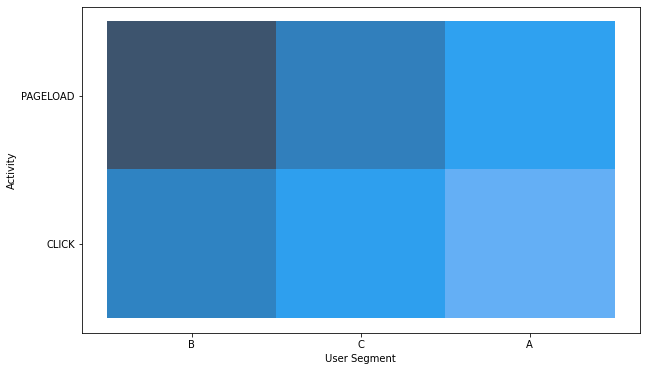

In [80]:
plt.figure(figsize=(10,6))
sns.histplot( y="Activity", x='User Segment', data=l.loc[(~(l.ProductID.isnull())) &(~l.Activity.isnull()),['Activity','OS','User Segment']])
plt.show()

In [81]:
# 2 time users 

df2.loc[df2.UserID.isin(list(l[(~(l.ProductID.isnull())) &(l.Activity.isnull())].UserID)),'Activity'] ='PAGELOAD'

In [83]:
#and as per above graph, imputed the remaining with Pageload
df2.loc[df2.Activity.isnull(),'Activity']='PAGELOAD'

In [84]:
#No Null values in the data.
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590818 entries, 0 to 590895
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   VisitDateTime  590818 non-null  datetime64[ns]
 1   ProductID      590818 non-null  object        
 2   UserID         590818 non-null  object        
 3   Activity       590818 non-null  object        
 4   OS             590818 non-null  object        
 5   User Segment   590818 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 31.6+ MB


In [85]:
df2.UserID.nunique()

33984

### Feature Derivation


In [87]:
#Created a Dataframe for all users
dfinal=pd.DataFrame(user.UserID)
dfinal.head()

,UserID
0,U133159
1,U129368
2,U109654
3,U108998
4,U131393


Vintage

In [88]:
# Vintage - derived by subtracting signup date from  2018-05-28 
date=pd.to_datetime('2018-05-28 00:00:00.000')
#user['Signup Date']=user['Signup Date'].astype(str).apply(lambda x: datetime.strptime(str(x[0:19]), '%Y-%m-%d %H:%M:%S'))
user['Signup Date']=user['Signup Date'].astype(str).apply(lambda x : x.split('+')[0])
user['Signup Date']=pd.to_datetime(user['Signup Date'])
dfinal['User_Vintage']=user['Signup Date'].apply(lambda x : int(str(date-x).split(' ')[0])) # +int(str(date-x).split(' ')[2].split(':')[0])

In [89]:
dfinal.shape

(34050, 2)

In [90]:
#creating a new dataframe for calculations
a=df2.drop(columns='User Segment')

In [91]:
df.head()

,VisitDateTime,ProductID,UserID,Activity,OS
14,1526366895249000000,Pr100017,U106593,click,Android
21,1527058921790000000,Pr101008,U108297,NaN,Android
23,2018-05-10 06:28:53.391,Pr100241,U132443,NaN,Windows
24,2018-05-08 12:40:02.153,pr100495,U134616,click,Windows
33,2018-05-11 15:35:43.689,Pr100363,U130784,click,Chrome OS


In [92]:
a.UserID.nunique()

33984

Recently Viewed Product

In [93]:
#Recently viewed product - taken the product seen by user most recently
rvp=a.groupby('UserID')['VisitDateTime'].max().reset_index()
rvp['conc']=rvp.UserID+rvp.VisitDateTime.astype(str)


In [94]:
a['conc']=a.UserID+a.VisitDateTime.astype(str)
rvp.head()

,UserID,VisitDateTime,conc
0,U100002,2018-05-18 10:43:56.628,U1000022018-05-18 10:43:56.628
1,U100003,2018-05-25 02:17:48.606,U1000032018-05-25 02:17:48.606
2,U100004,2018-05-21 13:36:01.227,U1000042018-05-21 13:36:01.227
3,U100005,2018-05-26 01:06:32.043,U1000052018-05-26 01:06:32.043
4,U100006,2018-05-21 07:21:59.460,U1000062018-05-21 07:21:59.460


In [95]:

mvp=pd.merge(rvp,a[['conc','ProductID']],'left','conc')
mvp.drop_duplicates(inplace=True)

In [96]:
dfinal=pd.merge(dfinal,mvp[['UserID','ProductID']],'left','UserID')

In [97]:
dfinal.shape

(34050, 3)

In [98]:
dfinal.UserID.nunique()

34050

OS

In [99]:
# most used OS - derived the most used OS, if there are more than two, took the latest one

p=a.groupby(['OS','UserID'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,a.groupby(['UserID','OS'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','OS'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime_count.astype(str)
q=p.groupby('UserID')['VisitDateTime_count'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime_count']),'inner','UOS'  ,   )
r=pd.merge(r.groupby(['UserID'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual'])

In [100]:
dfinal=pd.merge(dfinal,r[['UserID','OS']],'left','UserID')

In [101]:
dfinal.shape

(34050, 4)

User Visited in last 7 days 

In [103]:
# No_of_days_Visited_7_Days
a['Visitday']=a['VisitDateTime'].astype(str).apply(lambda x : x.split(' ')[0])

b=a.drop(columns='VisitDateTime')
b=b[b.Visitday>='2018-05-21']

grouped_df = b. groupby("UserID").agg({"Visitday": "nunique"}).reset_index()

grouped_df

,UserID,Visitday
0,U100003,1
1,U100004,1
2,U100005,1
3,U100006,1
4,U100008,6
...,...,...
16395,U136149,1
16396,U136369,1
16397,U136582,1
16398,U136604,1


In [104]:
dfinal=pd.merge(dfinal,grouped_df,how='left',on='UserID')

In [105]:
dfinal.UserID.nunique()

34050

Pageloads and Clicks in Last 7 days

In [106]:
#Pageloads_last_7_days , Clicks_last_7_days

dfinal=pd.merge(dfinal,b[b.Activity=='CLICK'].groupby('UserID')['Activity'].count().reset_index(),'left','UserID' )
dfinal=pd.merge(dfinal,b[b.Activity=='PAGELOAD'].groupby('UserID')['Activity'].count().reset_index(),'left','UserID',suffixes=('_CLICK','_PAGELOAD'))

In [107]:
dfinal.head()

,UserID,User_Vintage,ProductID,OS,Visitday,Activity_CLICK,Activity_PAGELOAD
0,U133159,43,Pr100319,ANDROID,NaN,NaN,NaN
1,U129368,176,Pr100071,WINDOWS,NaN,NaN,NaN
2,U109654,1895,Pr100102,WINDOWS,NaN,NaN,NaN
3,U108998,129,Pr100527,WINDOWS,1.0,1.0,1.0
4,U131393,61,Pr100201,ANDROID,NaN,NaN,NaN


Distinct Products viewed in last 15 days 

In [108]:
# No_Of_Products_Viewed_15_Days

c=a[a.Visitday>='2018-05-13']

dfinal=pd.merge(dfinal,c. groupby("UserID").agg({"ProductID": "nunique"}).reset_index(),how='left',on='UserID',suffixes=['_Recently viewed','_view_last_15_days'])

In [109]:
dfinal.head()

,UserID,User_Vintage,ProductID_Recently viewed,OS,Visitday,Activity_CLICK,Activity_PAGELOAD,ProductID_view_last_15_days
0,U133159,43,Pr100319,ANDROID,NaN,NaN,NaN,NaN
1,U129368,176,Pr100071,WINDOWS,NaN,NaN,NaN,1.0
2,U109654,1895,Pr100102,WINDOWS,NaN,NaN,NaN,2.0
3,U108998,129,Pr100527,WINDOWS,1.0,1.0,1.0,1.0
4,U131393,61,Pr100201,ANDROID,NaN,NaN,NaN,NaN


Most Viewed Product in last 15 days

In [110]:
# Most_Viewed_product_15_Days



p=c.groupby(['ProductID','UserID'])['VisitDateTime'].count().reset_index()
p=pd.merge(p,c.groupby(['UserID','ProductID'])['VisitDateTime'].max().reset_index(),'inner',on=['UserID','ProductID'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p.VisitDateTime_count.astype(str)
q=p.groupby('UserID')['VisitDateTime_count'].max().reset_index()
q['UOS']=q.UserID+q.VisitDateTime_count.astype(str)
r=pd.merge(q,p.drop(columns=['UserID','VisitDateTime_count']),'inner','UOS'  ,   )
r=pd.merge(r.groupby(['UserID'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual'])

In [111]:
dfinal=pd.merge(dfinal,r[['UserID','ProductID']],'left','UserID')

In [112]:
dfinal.shape

(34050, 9)

In [113]:
dfinal.UserID.nunique()

34050

In [114]:
dfinal=dfinal.iloc[:,[0,4,7,1,8,3,2,6,5]]

In [115]:
dfinal.columns=['UserID','No_of_days_Visited_7_Days','No_Of_Products_Viewed_15_Days','User_Vintage','Most_Viewed_product_15_Days','Most_Active_OS','Recently_Viewed_Product','Pageloads_last_7_days','Clicks_last_7_days']

In [116]:
dfinal.head()

,UserID,No_of_days_Visited_7_Days,No_Of_Products_Viewed_15_Days,User_Vintage,Most_Viewed_product_15_Days,Most_Active_OS,Recently_Viewed_Product,Pageloads_last_7_days,Clicks_last_7_days
0,U133159,NaN,NaN,43,NaN,ANDROID,Pr100319,NaN,NaN
1,U129368,NaN,1.0,176,Pr100071,WINDOWS,Pr100071,NaN,NaN
2,U109654,NaN,2.0,1895,Pr100102,WINDOWS,Pr100102,NaN,NaN
3,U108998,1.0,1.0,129,Pr100527,WINDOWS,Pr100527,1.0,1.0
4,U131393,NaN,NaN,61,NaN,ANDROID,Pr100201,NaN,NaN


Deriving the information from the 66 users filted above

In [117]:
missing_users_info.head()

,VisitDateTime,ProductID,UserID,Activity,OS,User Segment
28,NaN,NaN,U109407,CLICK,WINDOWS,A
30,NaN,NaN,U101050,PAGELOAD,WINDOWS,B
43,NaN,Pr101071,U104593,PAGELOAD,ANDROID,C
44,NaN,NaN,U104481,PAGELOAD,ANDROID,B
54,NaN,NaN,U111513,NaN,WINDOWS,A


In [118]:
# filling Most Active OS 

p=missing_users_info[missing_users_info.VisitDateTime.isnull()].groupby(['OS','UserID'])['User Segment'].count().reset_index()
#p=pd.merge(p,x2.groupby(['UserID','OS_y'])['User Segment'].max().reset_index(),'inner',on=['UserID','OS_y'],suffixes=['_count','_Actual'])
p['UOS']=p.UserID+p['User Segment'].astype(str)
q=p.groupby('UserID')['User Segment'].max().reset_index()
q['UOS']=q.UserID+q['User Segment'].astype(str)
r=pd.merge(q,p.drop(columns=['UserID','User Segment']),'inner','UOS'  ,   )
#r=pd.merge(r.groupby(['UserID'])['VisitDateTime_Actual'].max().reset_index(),r.drop(columns=['UOS','VisitDateTime_count']),'inner',on=['UserID','VisitDateTime_Actual'])

In [119]:
usr=pd.merge(dfinal[dfinal.UserID.isin(set(missing_users_info.UserID))],r.drop(columns=['User Segment','UOS']),'inner','UserID')

In [120]:
usr.head()

,UserID,No_of_days_Visited_7_Days,No_Of_Products_Viewed_15_Days,User_Vintage,Most_Viewed_product_15_Days,Most_Active_OS,Recently_Viewed_Product,Pageloads_last_7_days,Clicks_last_7_days,OS
0,U109160,NaN,NaN,85,NaN,NaN,NaN,NaN,NaN,ANDROID
1,U129809,NaN,NaN,122,NaN,NaN,NaN,NaN,NaN,WINDOWS
2,U128249,NaN,NaN,198,NaN,NaN,NaN,NaN,NaN,ANDROID
3,U116562,NaN,NaN,294,NaN,NaN,NaN,NaN,NaN,IOS
4,U122708,NaN,NaN,684,NaN,NaN,NaN,NaN,NaN,ANDROID


In [121]:
usr.drop(columns=['Most_Active_OS'],inplace=True)
usr=usr.iloc[:,[0,1,2,3,4,8,5,6,7]]
usr.columns=['UserID','No_of_days_Visited_7_Days','No_Of_Products_Viewed_15_Days','User_Vintage','Most_Viewed_product_15_Days','Most_Active_OS','Recently_Viewed_Product','Pageloads_last_7_days','Clicks_last_7_days']


In [122]:
usr.head()

,UserID,No_of_days_Visited_7_Days,No_Of_Products_Viewed_15_Days,User_Vintage,Most_Viewed_product_15_Days,Most_Active_OS,Recently_Viewed_Product,Pageloads_last_7_days,Clicks_last_7_days
0,U109160,NaN,NaN,85,NaN,ANDROID,NaN,NaN,NaN
1,U129809,NaN,NaN,122,NaN,WINDOWS,NaN,NaN,NaN
2,U128249,NaN,NaN,198,NaN,ANDROID,NaN,NaN,NaN
3,U116562,NaN,NaN,294,NaN,IOS,NaN,NaN,NaN
4,U122708,NaN,NaN,684,NaN,ANDROID,NaN,NaN,NaN


In [123]:
# filling most recently viewed product (for single time users)  having Visitordatetime null 


usr=pd.merge(usr,x2.loc[(x2.OS_x==1) &(x2.VisitDateTime.isnull()) ,['ProductID','UserID']],'left','UserID')



In [125]:
usr.drop(columns=['Recently_Viewed_Product'],inplace=True)
usr=usr.iloc[:,[0,1,2,3,4,5,8,6,7]]
usr.columns=['UserID','No_of_days_Visited_7_Days','No_Of_Products_Viewed_15_Days','User_Vintage','Most_Viewed_product_15_Days','Most_Active_OS','Recently_Viewed_Product','Pageloads_last_7_days','Clicks_last_7_days']


In [127]:
dfinal=pd.concat([usr,dfinal[~dfinal.UserID.isin(set(missing_users_info.UserID))]])

In [128]:
#replacing Null products with Product101
dfinal.Most_Viewed_product_15_Days=dfinal.Most_Viewed_product_15_Days.fillna('Product101')
dfinal.Recently_Viewed_Product=dfinal.Recently_Viewed_Product.fillna('Product101')

In [129]:
#Converting the numerical columns to int
for i in dfinal.columns:
  if dfinal[i].dtype!='O':
    dfinal[i]=dfinal[i].fillna(0).astype(int)
    


In [130]:
dfinal.sort_values(by=['UserID'], inplace=True)
dfinal.reset_index(drop=True,inplace=True)
dfinal.head()

,UserID,No_of_days_Visited_7_Days,No_Of_Products_Viewed_15_Days,User_Vintage,Most_Viewed_product_15_Days,Most_Active_OS,Recently_Viewed_Product,Pageloads_last_7_days,Clicks_last_7_days
0,U100002,0,2,52,Pr100258,ANDROID,Pr100258,0,0
1,U100003,1,2,1020,Pr100079,WINDOWS,Pr100079,1,2
2,U100004,1,15,340,Pr100753,WINDOWS,Pr100753,1,0
3,U100005,1,3,680,Pr100234,ANDROID,Pr100234,2,0
4,U100006,1,1,54,Pr101111,ANDROID,Pr101111,1,0


In [131]:
dfinal.UserID.nunique()

34050

In [132]:
dfinal.to_csv("/content/gdrive/MyDrive/Colab Notebooks/data_sub.csv",index=False)

In [133]:
dfinal.shape

(34050, 9)